## Setup

In [4]:
import os, sys, math, zipfile, urllib.request
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from types import SimpleNamespace

REPO = "/root/work/LIB"
sys.path.insert(0, REPO)
sys.path.insert(0, os.path.join(REPO, "src"))

from optimizers.main import get_optimizer

torch.manual_seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float32
print("device:", device, "dtype:", dtype)

device: cuda dtype: torch.float32


## Загрузка данных MovieLens 100K


In [5]:
DATA_DIR = "."
os.makedirs(DATA_DIR, exist_ok=True)

zip_path = os.path.join(DATA_DIR, "ml-100k.zip")
extract_dir = os.path.join(DATA_DIR, "ml-100k")

if not os.path.exists(extract_dir):
    if not os.path.exists(zip_path):
        url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
        print("Downloading:", url)
        urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(DATA_DIR)

ratings_path = os.path.join(extract_dir, "u.data")
print("ratings_path:", ratings_path)

ratings_path: ./ml-100k/u.data


`u.data` формат: `user_id  item_id  rating  timestamp`.

In [7]:
def load_movielens_100k(path):
    # user_id, item_id начинаются с 1
    rows = []
    with open(path, "r") as f:
        for line in f:
            u, i, r, t = line.strip().split()
            rows.append((int(u)-1, int(i)-1, float(r), int(t)))
    arr = np.array(rows, dtype=object)
    users = arr[:,0].astype(np.int64)
    items = arr[:,1].astype(np.int64)
    ratings = arr[:,2].astype(np.float32)
    ts = arr[:,3].astype(np.int64)
    m = users.max()+1
    n = items.max()+1
    return users, items, ratings, ts, m, n

users, items, ratings, ts, m, n = load_movielens_100k(ratings_path)
print("m (users) =", m, "n (items) =", n, "N =", len(ratings))

m (users) = 943 n (items) = 1682 N = 100000


## Train/Val split

Сделаем split по timestamp: последние 10% — валидация.

In [8]:
N = len(ratings)
order = np.argsort(ts)
split = int(0.9 * N)
train_idx = order[:split]
val_idx   = order[split:]

train_data = (users[train_idx], items[train_idx], ratings[train_idx])
val_data   = (users[val_idx],   items[val_idx],   ratings[val_idx])

print("train:", len(train_idx), "val:", len(val_idx))

train: 90000 val: 10000


## Dataset/DataLoader

In [16]:
class RatingsDataset(Dataset):
    def __init__(self, u, i, r):
        self.u = torch.from_numpy(u).long()
        self.i = torch.from_numpy(i).long()
        self.r = torch.from_numpy(r).float()
    def __len__(self): return len(self.r)
    def __getitem__(self, idx):
        return self.u[idx], self.i[idx], self.r[idx]

batch_size = 4096
train_loader = DataLoader(RatingsDataset(*train_data), batch_size=batch_size, shuffle=True, drop_last=False)
val_loader   = DataLoader(RatingsDataset(*val_data),   batch_size=batch_size, shuffle=False, drop_last=False)

## Модель факторизации ($W = U V^\top$) (+ опционально bias)

In [17]:
class MF(nn.Module):
    def __init__(self, m, n, r, use_bias=True, device="cpu", dtype=torch.float32):
        super().__init__()
        self.U = nn.Parameter(0.01 * torch.randn(m, r, device=device, dtype=dtype))
        self.V = nn.Parameter(0.01 * torch.randn(n, r, device=device, dtype=dtype))
        self.use_bias = use_bias
        if use_bias:
            self.bu = nn.Parameter(torch.zeros(m, device=device, dtype=dtype))
            self.bi = nn.Parameter(torch.zeros(n, device=device, dtype=dtype))
            self.mu = nn.Parameter(torch.tensor(0.0, device=device, dtype=dtype))

    def forward(self, u_idx, i_idx):
        pred = (self.U[u_idx] * self.V[i_idx]).sum(dim=-1)
        if self.use_bias:
            pred = pred + self.bu[u_idx] + self.bi[i_idx] + self.mu
        return pred

## RMSE и “эффективный ранг”

Не делаем SVD ($ 943\times 1682 $).
У матрицы $UV^\top$ ранг $\le r$, её сингулярные значения равны сингулярным значениям маленькой матрицы $R_U R_V^\top$ после QR.


In [18]:
@torch.no_grad()
def rmse(model, loader):
        se, cnt = 0.0, 0
        for u, i, r in loader:
            u = u.to(device); i = i.to(device); r = r.to(device)
            pred = model(u, i)
            se += ((pred - r) ** 2).sum().item()
            cnt += r.numel()
        return math.sqrt(se / cnt)

@torch.no_grad()
def effective_rank_from_UV(U, V, eps=1e-12):
    # U: [m,r], V: [n,r]
    # QR thin
    Qu, Ru = torch.linalg.qr(U, mode="reduced")   # Ru: [r,r]
    Qv, Rv = torch.linalg.qr(V, mode="reduced")   # Rv: [r,r]
    S = torch.linalg.svdvals(Ru @ Rv.T)           # [r]
    # entropy effective rank: exp(H(p)), p = S/sum(S)
    p = S / (S.sum() + eps)
    H = -(p * (p + eps).log()).sum()
    erank = torch.exp(H).item()
    # stable rank: ||W||_F^2 / ||W||_2^2 = sum(S^2) / max(S)^2
    srank = (S.pow(2).sum() / (S.max()**2 + eps)).item()
    return erank, srank, S.detach().cpu().numpy()

## AdamW vs MuAdam из LIB


* `adamw`
* `muadam` / `taia` + `lmo='spectral'` + `precondition_type='adam'`)

In [24]:
def make_optimizer(kind, model, lr, ns_steps=10, weight_decay=0.0, eps=1e-8):
    if kind == "adamw":
        args = SimpleNamespace(optimizer="adamw", lr=lr, eps=eps, weight_decay=weight_decay,
                               beta1=0.9, beta2=0.999, momentum=0.0, ns_steps=0,
                               adamw_lr=lr, update_freq=1, shampoo_beta=0.9)
        return get_optimizer(args, model)

    if kind == "muadam":
        args = SimpleNamespace(optimizer="muadam", lr=lr, eps=eps, weight_decay=weight_decay,
                               beta1=0.9, beta2=0.999, momentum=0.9, ns_steps=ns_steps,
                               adamw_lr=lr, update_freq=1, shampoo_beta=0.9,
                               lmo="spectral", precondition_type="adam")
        return get_optimizer(args, model)

    if kind == "taia_muadam":
        args = SimpleNamespace(optimizer="taia", lr=lr, eps=eps, weight_decay=weight_decay,
                               beta1=0.9, beta2=0.999, momentum=0.9, ns_steps=ns_steps,
                               adamw_lr=lr, update_freq=1, shampoo_beta=0.9,
                               lmo="spectral", precondition_type="adam")
        return get_optimizer(args, model)

    raise ValueError("unknown kind")

## Train loop

In [32]:
def train_one(kind, r=16, lr=1e-2, epochs=10, ns_steps=10, use_bias=True, wd=0.0, lambda_uv=1e-4):
    model = MF(m, n, r, use_bias=use_bias, device=device, dtype=dtype).to(device)
    opt = make_optimizer(kind, model, lr=lr, ns_steps=ns_steps, weight_decay=wd)

    history = {"epoch": [], "train_rmse": [], "val_rmse": [], "erank": [], "srank": []}

    for ep in range(1, epochs+1):
        model.train()
        for batch_idx, (u, i, r_) in enumerate(train_loader):
            u = u.to(device); i = i.to(device); r_ = r_.to(device)
            pred = model(u, i)
            mse = ((pred - r_) ** 2).mean()
            reg = lambda_uv * (model.U.pow(2).sum() + model.V.pow(2).sum()) / (model.U.numel() + model.V.numel())
            loss = mse + reg

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            if batch_idx % 10 == 0:
                print("mse", mse.item(), "reg", reg.item(), "loss", loss.item())

            opt.step()
            opt.zero_grad(set_to_none=True)

        model.eval()
        tr = rmse(model, train_loader)
        va = rmse(model, val_loader)
        er, sr, _ = effective_rank_from_UV(model.U.data, model.V.data)

        history["epoch"].append(ep)
        history["train_rmse"].append(tr)
        history["val_rmse"].append(va)
        history["erank"].append(er)
        history["srank"].append(sr)

        print(f"[{kind}] ep={ep:02d} train_rmse={tr:.4f} val_rmse={va:.4f} erank={er:.2f} srank={sr:.2f}")

    return model, history

## Запуск сравнения AdamW vs MuAdam

In [33]:
rank = 16
epochs = 15

lambda_uv = 1e-3

model_adamw, h_adamw = train_one("adamw", r=rank, lr=1e-2, epochs=epochs, use_bias=True, wd=0.0, lambda_uv=lambda_uv)

# "muadam" или "taia_muadam"
model_muadam, h_muadam = train_one("muadam", r=rank, lr=1e-2, epochs=epochs, ns_steps=10, use_bias=True, wd=0.0, lambda_uv=lambda_uv)

model_muadam_sania, h_muadam_sania = train_one("taia_muadam", r=rank, lr=1e-2, epochs=epochs, ns_steps=10, use_bias=True, wd=0.0, lambda_uv=lambda_uv)


mse 13.59152889251709 reg 1.0099007141661787e-07 loss 13.59152889251709
mse 11.472419738769531 reg 1.6849448911671061e-06 loss 11.472421646118164
mse 8.718151092529297 reg 9.941742973751388e-06 loss 8.718160629272461
[adamw] ep=01 train_rmse=2.8139 val_rmse=3.2557 erank=1.80 srank=1.00
mse 7.857268810272217 reg 1.3180908354115672e-05 loss 7.8572821617126465
mse 3.915489673614502 reg 4.018926847493276e-05 loss 3.91552996635437
mse 1.2370158433914185 reg 8.506567974109203e-05 loss 1.2371009588241577
[adamw] ep=02 train_rmse=1.0515 val_rmse=2.6134 erank=1.13 srank=1.00
mse 1.1077966690063477 reg 9.38711964408867e-05 loss 1.1078904867172241
mse 0.9706621766090393 reg 0.00010999794903909788 loss 0.9707721471786499
mse 0.9312149882316589 reg 0.00010698930418584496 loss 0.9313219785690308
[adamw] ep=03 train_rmse=0.9438 val_rmse=2.5587 erank=1.13 srank=1.00
mse 0.8288406133651733 reg 0.0001075332475011237 loss 0.8289481401443481
mse 0.898154616355896 reg 0.00011430193262640387 loss 0.89826893

## Графики val RMSE + effective rank

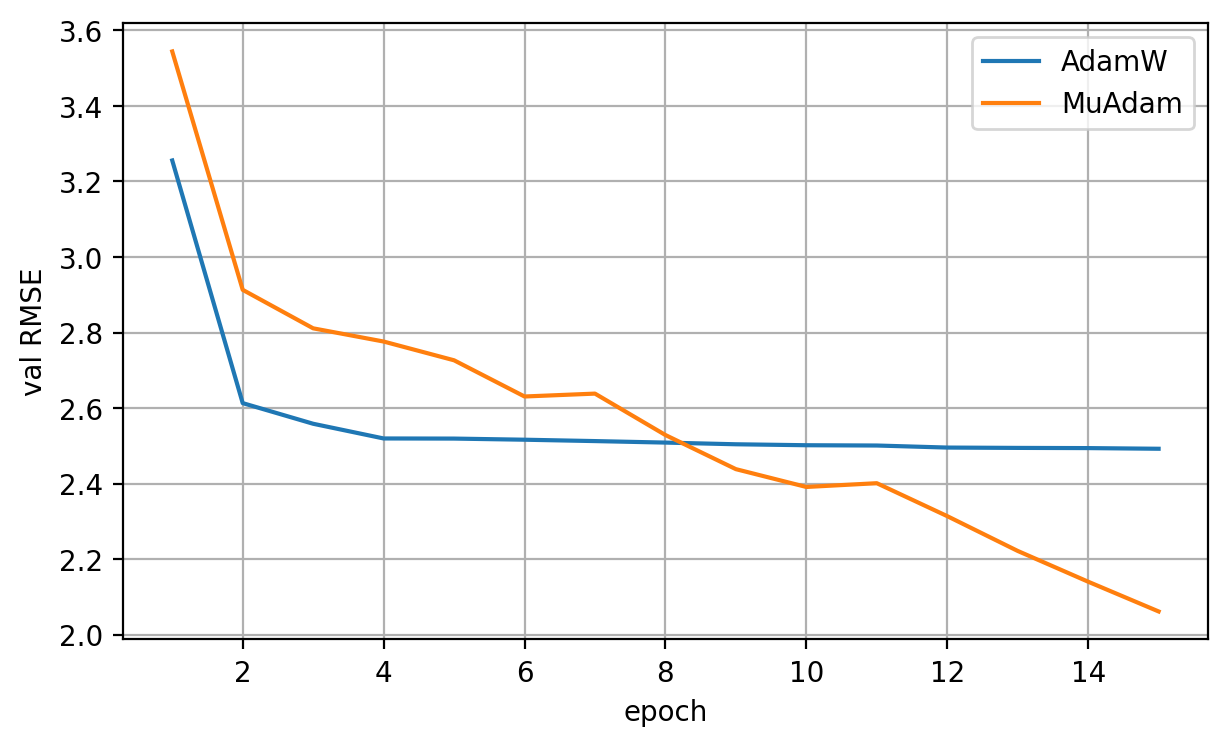

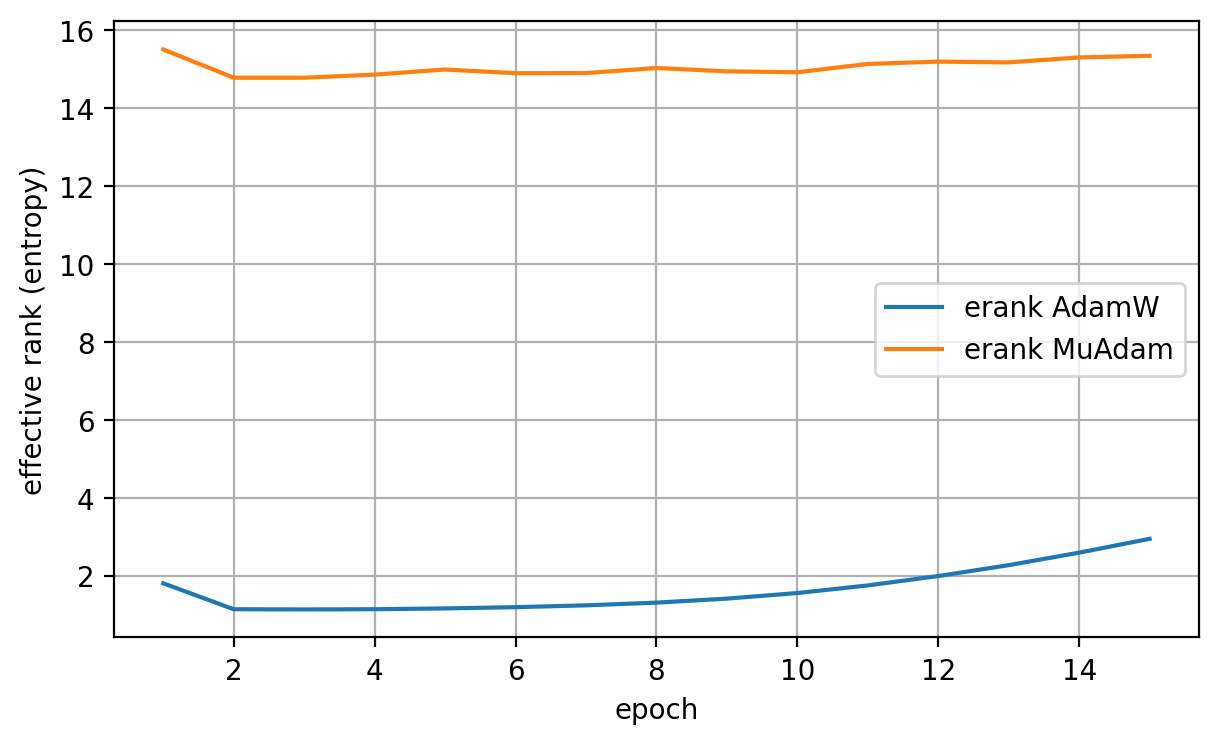

In [36]:
def plot_histories(h1, label1, h2, label2):
    plt.figure(figsize=(7,4), dpi=200)
    plt.plot(h1["epoch"], h1["val_rmse"], label=label1)
    plt.plot(h2["epoch"], h2["val_rmse"], label=label2)
    plt.xlabel("epoch"); plt.ylabel("val RMSE"); plt.grid(True); plt.legend()
    plt.show()

    plt.figure(figsize=(7,4), dpi=200)
    plt.plot(h1["epoch"], h1["erank"], label=f"erank {label1}")
    plt.plot(h2["epoch"], h2["erank"], label=f"erank {label2}")
    plt.xlabel("epoch"); plt.ylabel("effective rank (entropy)"); plt.grid(True); plt.legend()
    plt.show()

plot_histories(h_adamw, "AdamW", h_muadam, "MuAdam")

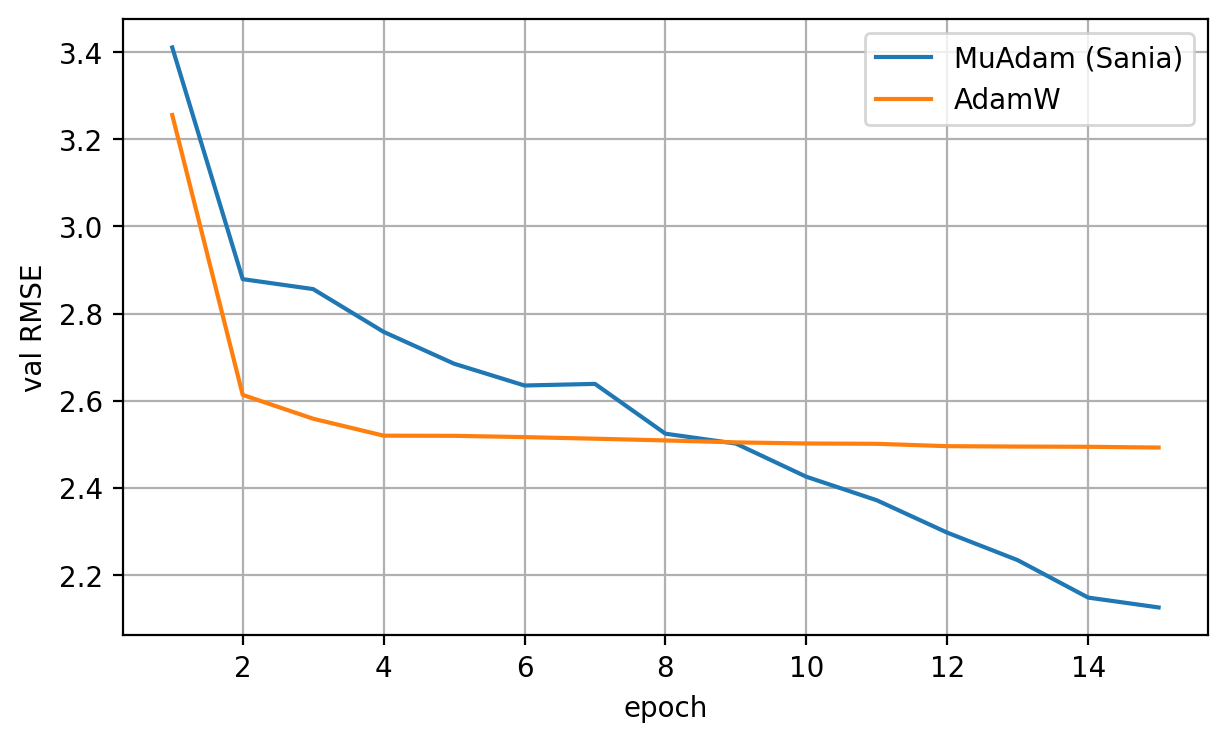

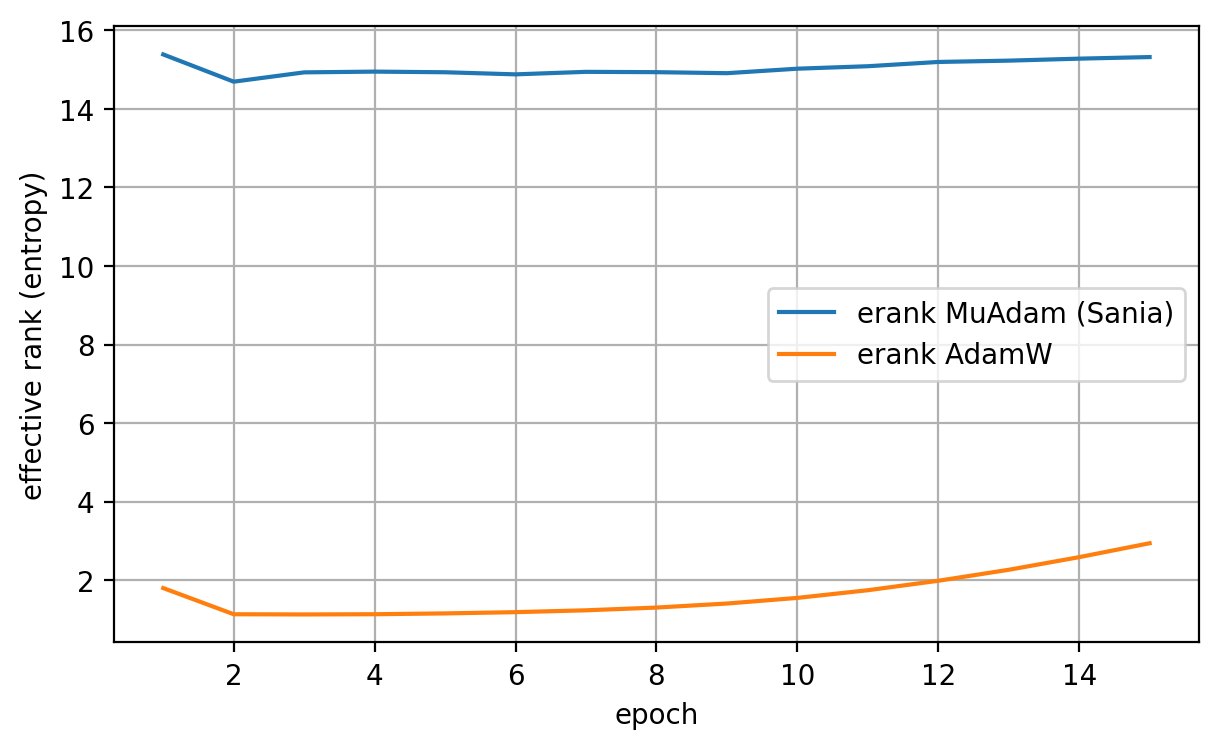

In [37]:
def plot_histories(h1, label1, h2, label2):
    plt.figure(figsize=(7,4), dpi=200)
    plt.plot(h1["epoch"], h1["val_rmse"], label=label1)
    plt.plot(h2["epoch"], h2["val_rmse"], label=label2)
    plt.xlabel("epoch"); plt.ylabel("val RMSE"); plt.grid(True); plt.legend()
    plt.show()

    plt.figure(figsize=(7,4), dpi=200)
    plt.plot(h1["epoch"], h1["erank"], label=f"erank {label1}")
    plt.plot(h2["epoch"], h2["erank"], label=f"erank {label2}")
    plt.xlabel("epoch"); plt.ylabel("effective rank (entropy)"); plt.grid(True); plt.legend()
    plt.show()

plot_histories(h_muadam_sania, "MuAdam (Sania)", h_adamw, "AdamW")

## Вывод

* AdamW демонстрирует стабильную сходимость и хорошую генерализацию за счёт неявной низкоранговой регуляризации: эффективный ранг растёт медленно и остаётся малым.

* MuAdam / MuAdam-SANIA достигают более низкой валидационной ошибки, но поддерживают высокий эффективный ранг, это указывает на улучшение оптимизации за счёт геометрии обновлений.

